# Load Data and Word-Embedding Models

In [50]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('ATE_train.json', 'r'))
val_data = json.load(open('ATE_val.json', 'r'))
test_data = json.load(open('ATE_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [51]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# BiLSTM-CRF Implementation


In [52]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, input_size, hidden_size, num_tags):
        super(BiLSTM_CRF, self).__init__()
        self.hidden_size = hidden_size
        self.num_tags = num_tags
        # BiLSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(2*hidden_size, num_tags)
        # CRF layer
        self.crf = CRF(num_tags)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def neg_log_likelihood(self, x, tags):
        emissions = self(x)
        return -self.crf(emissions, tags)

    def forward_crf(self, x):
        emissions = self(x)
        out = self.crf.decode(emissions)
        out = torch.tensor(out)
        out = torch.nn.functional.one_hot(out, num_classes=self.num_tags)
        out = out.permute(1, 0, 2) # (len, 1, num_tags) to (1, len, num_tags)
        out = out.to(device=x.device)
        return out

# Example usage:
input_size = 300  # Example input size
hidden_size = 128  # Example hidden size
num_tags = 27  # Example number of tags
criteria = nn.CrossEntropyLoss()

# Example forward pass with CRF
model = BiLSTM_CRF(input_size, hidden_size, num_tags)
inputs = torch.randn(1, 19, input_size)  # Example input tensor
tags = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])  # Example tag tensor

neg_log_likelihood = model.neg_log_likelihood(inputs, tags)
decoded_tags = model.forward_crf(inputs)
print(inputs.shape, tags.shape)
print(decoded_tags.shape)
loss = criteria(decoded_tags.float().view(-1, 27), tags.squeeze(0))
print(neg_log_likelihood)

torch.Size([1, 19, 300]) torch.Size([1, 19])
torch.Size([1, 19, 27])
tensor(62.6478, grad_fn=<NegBackward0>)


# Training and Validation Code

In [53]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {"B": 0, "I": 1, "O": 2}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            # Compute loss
            # targets = targets.squeeze(0)
            # loss = criterion(outputs.float().view(-1, output_size), targets)
            loss = model.neg_log_likelihood(embedded_text, targets)
            targets = targets.squeeze(0)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"].split()
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model.forward_crf(embedded_text)
                # Compute loss
                # targets = targets.squeeze(0)
                # loss = criterion(outputs.float().view(-1, output_size), targets)
                loss = model.neg_log_likelihood(embedded_text, targets)
                targets = targets.squeeze(0)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [54]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)  
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            targets = targets.squeeze(0)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
        
    if show_labelwise:
        import matplotlib.pyplot as plt
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [55]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [56]:
input_size = 300  # Embedding size
hidden_size = 128  # Hidden size of the RNN
output_size = 3   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [57]:
bilstmcrf_word2vec_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_word2vec_model.parameters(), lr=0.001)

In [58]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 4.6883, Accuracy: 0.9174, F1: 0.6336
Validation: Loss: 2.8722, Accuracy: 0.9463, F1: 0.7723
Epoch 2/10
Training: Loss: 2.9653, Accuracy: 0.9455, F1: 0.7915
Validation: Loss: 2.6545, Accuracy: 0.9495, F1: 0.7853
Epoch 3/10
Training: Loss: 2.3062, Accuracy: 0.9573, F1: 0.8439
Validation: Loss: 2.5659, Accuracy: 0.9543, F1: 0.8073
Epoch 4/10
Training: Loss: 1.6989, Accuracy: 0.9693, F1: 0.8889
Validation: Loss: 2.8078, Accuracy: 0.9504, F1: 0.8086
Epoch 5/10
Training: Loss: 1.1579, Accuracy: 0.9803, F1: 0.9329
Validation: Loss: 3.1678, Accuracy: 0.9497, F1: 0.7978
Epoch 6/10
Training: Loss: 0.7493, Accuracy: 0.9884, F1: 0.9625
Validation: Loss: 3.4036, Accuracy: 0.9502, F1: 0.8011
Epoch 7/10
Training: Loss: 0.5146, Accuracy: 0.9925, F1: 0.9744
Validation: Loss: 3.7468, Accuracy: 0.9514, F1: 0.8055
Epoch 8/10
Training: Loss: 0.3741, Accuracy: 0.9944, F1: 0.9811
Validation: Loss: 3.9320, Accuracy: 0.9502, F1: 0.8158
Epoch 9/10
Training: Loss: 0.2972, Accuracy: 0.9

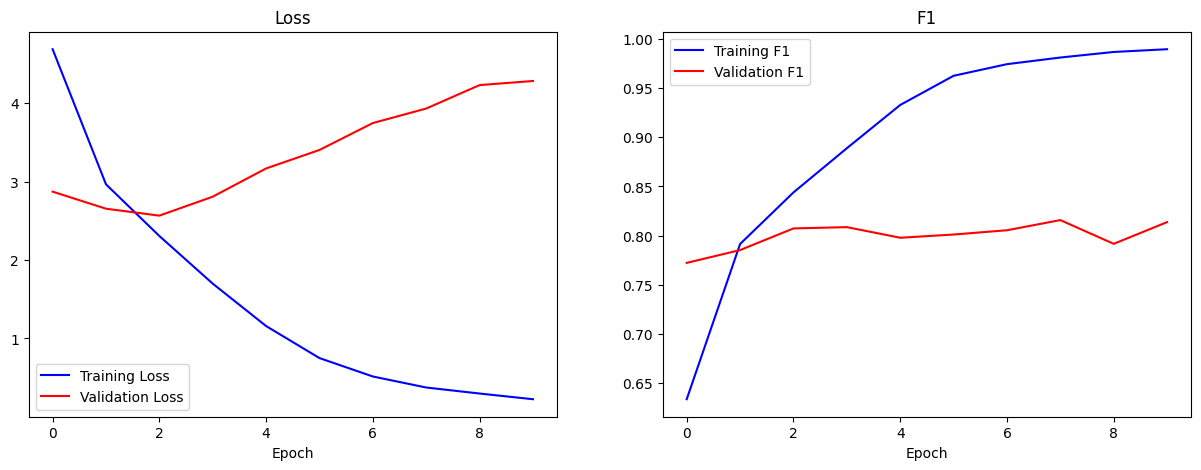

In [59]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [61]:
bilstmcrf_word2vec_model = bilstmcrf_word2vec_model.to('cpu')
torch.save(bilstmcrf_word2vec_model, "t2_model4_word2vec.pt")

Labelwise F1 Scores:
{0: 0.2952266345768151, 1: 0.2469775474956822, 2: 0.3286011735756199}
Labelwise Accuracy Scores:
{0: 0.7948164146868251, 1: 0.588477366255144, 2: 0.9720044792833147}


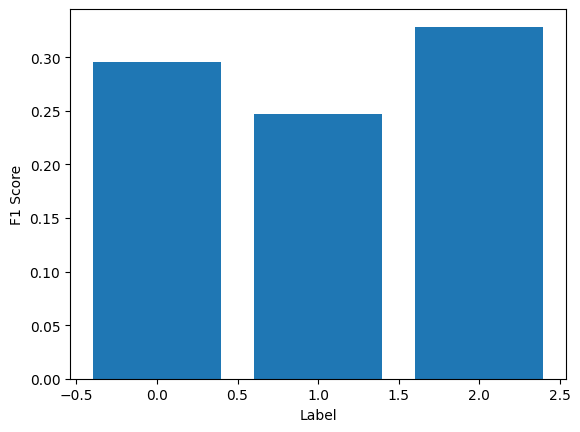

Bi-LSTM CRF with Word2Vec ==> Accuracy: 0.9381, F1: 0.8010


In [60]:
test_accuracy, test_f1 = test("t2_model4_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

# For GloVe Embeddings

In [82]:
input_size, hidden_size, output_size = 300, 128, 3
bilstmcrf_glove_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_glove_model.parameters(), lr=0.001)

In [83]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=5)

Epoch 1/5
Training: Loss: 4.7189, Accuracy: 0.9159, F1: 0.6173
Validation: Loss: 3.4172, Accuracy: 0.9358, F1: 0.7053
Epoch 2/5
Training: Loss: 3.1036, Accuracy: 0.9420, F1: 0.7633
Validation: Loss: 3.2924, Accuracy: 0.9387, F1: 0.7180
Epoch 3/5
Training: Loss: 2.1763, Accuracy: 0.9591, F1: 0.8445
Validation: Loss: 3.2766, Accuracy: 0.9411, F1: 0.7364
Epoch 4/5
Training: Loss: 1.3731, Accuracy: 0.9752, F1: 0.9121
Validation: Loss: 3.5534, Accuracy: 0.9435, F1: 0.7560
Epoch 5/5
Training: Loss: 0.9250, Accuracy: 0.9843, F1: 0.9476
Validation: Loss: 3.7709, Accuracy: 0.9401, F1: 0.7540


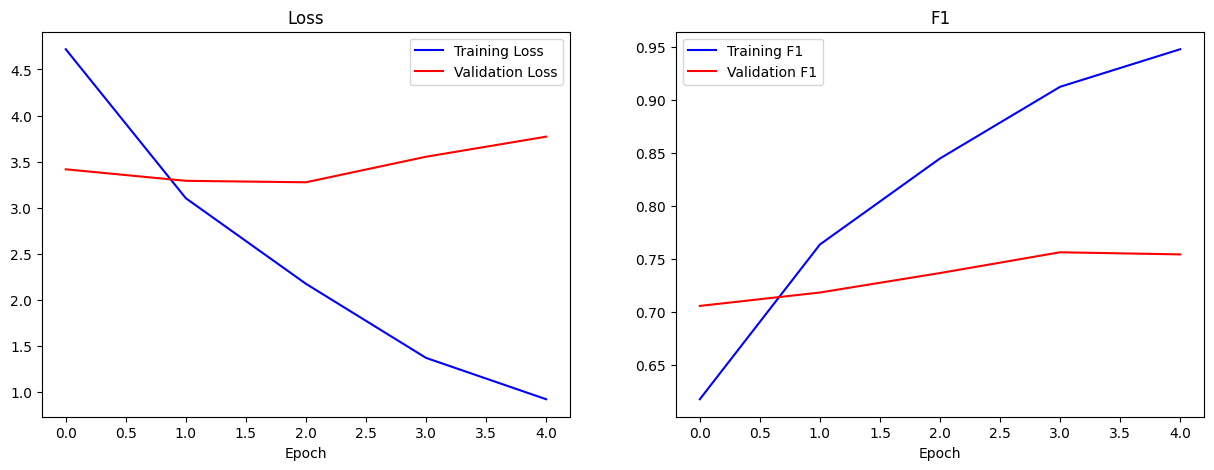

In [84]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [85]:
bilstmcrf_glove_model = bilstmcrf_glove_model.to('cpu')
torch.save(bilstmcrf_glove_model, "t2_model4_glove.pt")

Labelwise F1 Scores:
{0: 0.2583774250440917, 1: 0.21791320406278855, 2: 0.32936732766761095}
Labelwise Accuracy Scores:
{0: 0.6328293736501079, 1: 0.48559670781893005, 2: 0.9764837625979843}


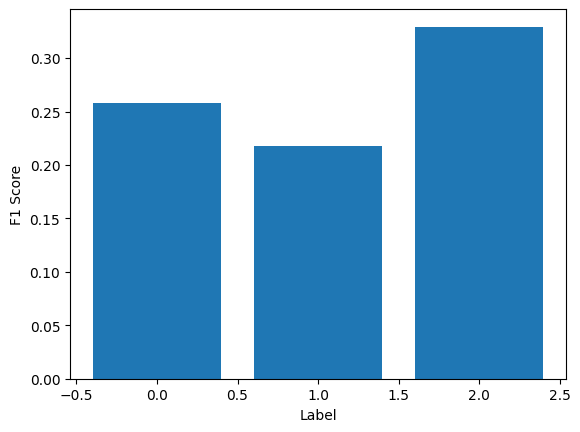

Bi-LSTM CRF with GloVe ==> Accuracy: 0.9226, F1: 0.7418


In [86]:
test_accuracy, test_f1 = test("t2_model4_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

# For FastText Embeddings

In [107]:
input_size, hidden_size, output_size = 300, 64, 3
bisltmcrf_fasttext_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bisltmcrf_fasttext_model.parameters(), lr=0.001)

In [108]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        bisltmcrf_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=5)

Epoch 1/5
Training: Loss: 5.3498, Accuracy: 0.9058, F1: 0.5151
Validation: Loss: 3.1889, Accuracy: 0.9327, F1: 0.6849
Epoch 2/5
Training: Loss: 3.1598, Accuracy: 0.9375, F1: 0.7547
Validation: Loss: 2.8395, Accuracy: 0.9454, F1: 0.7598
Epoch 3/5
Training: Loss: 2.6840, Accuracy: 0.9466, F1: 0.8002
Validation: Loss: 2.7368, Accuracy: 0.9466, F1: 0.7699
Epoch 4/5
Training: Loss: 2.3314, Accuracy: 0.9549, F1: 0.8376
Validation: Loss: 2.7004, Accuracy: 0.9471, F1: 0.7757
Epoch 5/5
Training: Loss: 2.0102, Accuracy: 0.9620, F1: 0.8672
Validation: Loss: 2.7796, Accuracy: 0.9442, F1: 0.7628


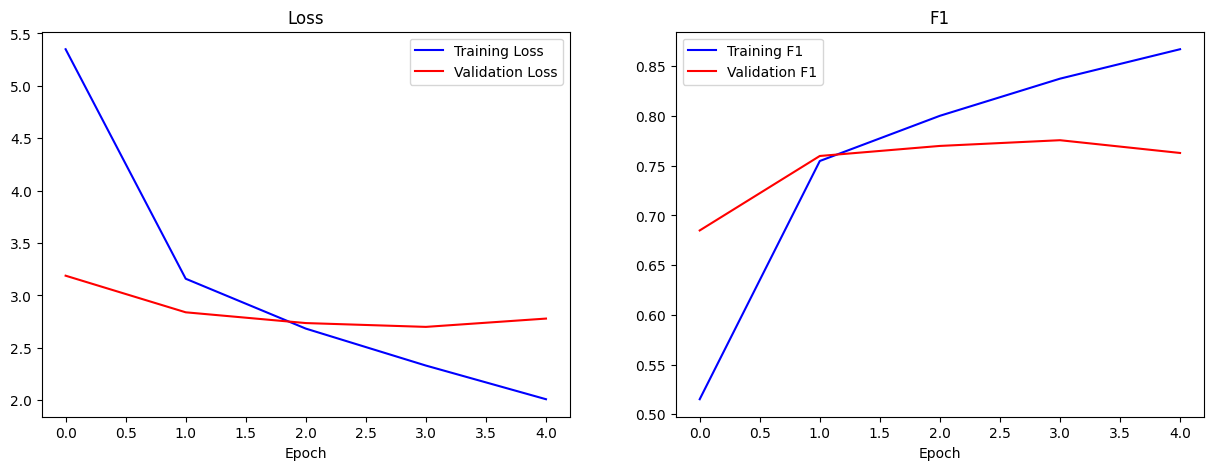

In [109]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [110]:
bisltmcrf_fasttext_model = bisltmcrf_fasttext_model.to('cpu')
torch.save(bisltmcrf_fasttext_model, "t2_model4_fasttext.pt")

Labelwise F1 Scores:
{0: 0.273960983884648, 1: 0.23922603342128404, 2: 0.3300919644203226}
Labelwise Accuracy Scores:
{0: 0.6976241900647948, 1: 0.5596707818930041, 2: 0.9807390817469205}


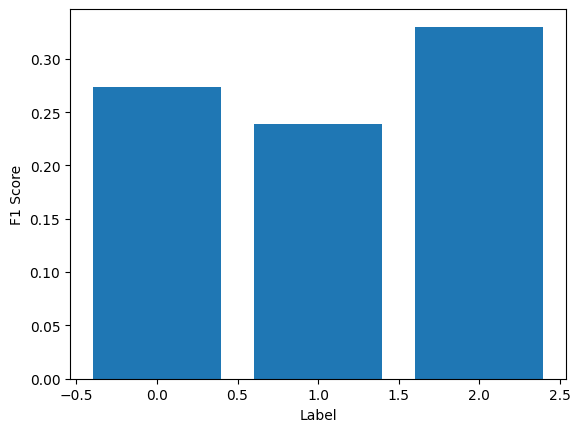

Bi-LSTM CRF with FastText ==> Accuracy: 0.9356, F1: 0.7884


In [111]:
test_accuracy, test_f1 = test("t2_model4_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))